In [3]:
# RPI = (DO + SS + BOD + NH3N) / 4
# NH3-N / NO3-N = K  -->  NH3-N = NO3-N * K

In [2]:
def cal_RPI(DO, SS, BOD, NH3N):
    return (DO + SS + BOD + NH3N) / 4

In [7]:
APRIL_RPI = cal_RPI(9.0, 15, 0, 1.3 * 3)
MAY_RPI = cal_RPI(8.4, 10, 0, 2.5 * 3.6)
JUNE_RPI = cal_RPI(8.5, 16, 0, 1.7 * 2)
JULY_RPI = cal_RPI(6.4, 24, 0, 2.6 * 2.3)
AUGUST_RPI = cal_RPI(8.1, 143, 0, 1.2 * 2.6)
SEPTEMBER_RPI = cal_RPI(7.7, 53, 0, 1.5 * 2.4)

In [12]:
folder_paths = ['./水質檢測/Image_data/1_April', 
                './水質檢測/Image_data/2_May',
                './水質檢測/Image_data/3_June',
                './水質檢測/Image_data/4_July',
                './水質檢測/Image_data/5_August',
                './水質檢測/Image_data/6_September']
labels = [APRIL_RPI, MAY_RPI, JUNE_RPI, JULY_RPI, AUGUST_RPI, SEPTEMBER_RPI]  # 对应文件夹1和文件夹2的标签

In [8]:
# Printing the calculated values
print("April RPI:", APRIL_RPI)
print("May RPI:", MAY_RPI)
print("June RPI:", JUNE_RPI)
print("July RPI:", JULY_RPI)
print("August RPI:", AUGUST_RPI)
print("September RPI:", SEPTEMBER_RPI)

April RPI: 6.975
May RPI: 6.85
June RPI: 6.975
July RPI: 9.094999999999999
August RPI: 38.555
September RPI: 16.075


In [11]:
# Since we have 2 value equal to 6.975.
# We should use 5 label to classify!

In [13]:
import tensorflow as tf
import os

def load_and_label_images(folder_path, label):
    image_paths = []  # 存储图像文件的路径
    labels = []       # 存储图像对应的标签

    # 获取文件夹中的所有图像文件的路径
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # 假设只加载jpg和png格式的图像文件
            image_paths.append(os.path.join(folder_path, filename))
            labels.append(label)

    # 加载图像并为其指定标签
    images = [tf.io.read_file(image_path) for image_path in image_paths]
    images = [tf.image.decode_image(image, channels=3) for image in images]

    # 可选的数据预处理：这里假设对图像进行归一化
    images = [tf.cast(image, tf.float32) / 255.0 for image in images]

    return images, labels

# 你可以根据需要加载多个文件夹中的图像并为其指定不同的标签
# folder_paths = ['/path/to/folder1', '/path/to/folder2']
# labels = [1, 2]  # 对应文件夹1和文件夹2的标签

# 加载所有文件夹中的图像和标签
all_images = []
all_labels = []
for folder_path, label in zip(folder_paths, labels):
    images, labels = load_and_label_images(folder_path, label)
    all_images.extend(images)
    all_labels.extend(labels)

# 构建数据集
dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels))

# 可选的打乱和分批处理
dataset = dataset.shuffle(buffer_size=len(all_images)).batch(batch_size=32)

2024-05-03 09:35:50.205782: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-05-03 09:35:50.205797: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-05-03 09:35:50.205803: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-05-03 09:35:50.205849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-03 09:35:50.206060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


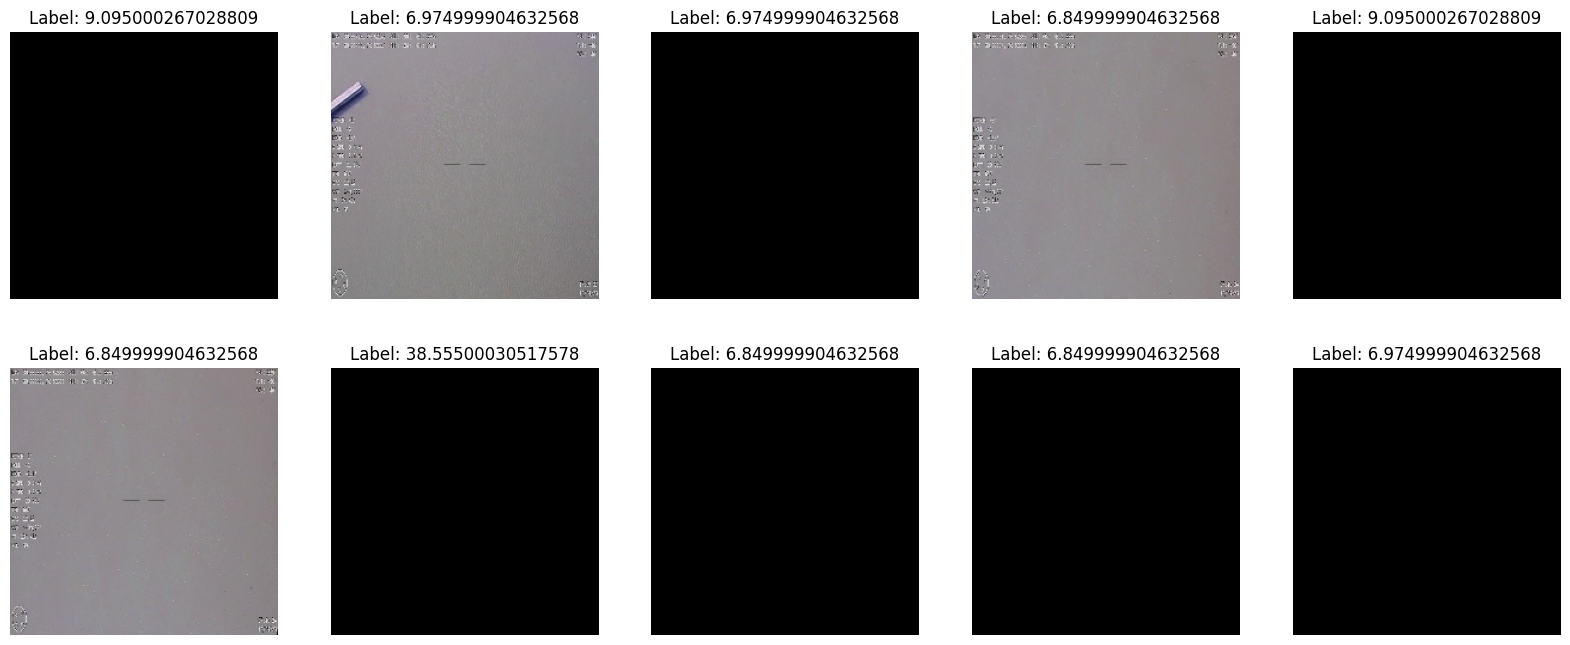

In [23]:
import matplotlib.pyplot as plt

# 从数据集中获取并显示图像
fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # 创建一个2x5的子图布局

for i, (image, label) in enumerate(dataset.take(10)):  # 取出前十张图像
    row = i // 5  # 计算当前图像应该位于的行索引
    col = i % 5   # 计算当前图像应该位于的列索引
    
    axs[row, col].imshow(image[0])  # 假设每个batch里只有一张图像
    axs[row, col].set_title('Label: {}'.format(label[0].numpy()))
    axs[row, col].axis('off')  # 关闭坐标轴

plt.show()

In [19]:
import tensorflow as tf

# 定义一个简单的卷积神经网络模型
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax') 
    ])
    return model

In [20]:
model = create_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.fit(dataset, epochs=10)

Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 8/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 10/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
